In [ ]:
!pip install git+https://github.com/tfjgeorge/nngeometry.git

In [27]:
## Imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output 
from sklearn.utils.extmath import randomized_svd
from nngeometry.object.fspace import FMatDense
from nngeometry.object.vector import FVector
from nngeometry.object import PMatImplicit
from nngeometry.generator import Jacobian
from nngeometry.layercollection import LayerCollection
clear_output()
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# !! fixed random seed! 

# Download training dataset
dataset = MNIST(root='data/', download=True)
vali_dataset = MNIST(root='data/', train=False)
print('data set length:',len(dataset),'vali data length:',len(vali_dataset))

# Transform to tensors
train_dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

# training data and validation data.
train_ds = train_dataset
val_ds = MNIST(root='data/', 
                train=False,
                transform=transforms.ToTensor())

data set length: 60000 vali data length: 10000


In [28]:
# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [29]:
# Build CNN models, 3 convolution layers.
def conv_block(input_channels, out_channels, kernel_size, padding, batch_norm = True, pool=True):
    layers = [nn.Conv2d(input_channels, out_channels, kernel_size, 1, padding)]
    if batch_norm: 
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def in_out_channel(in_channel=128, layer=1, rate=1/2, mode='exp'):
  if mode == 'exp':
    out_channel = int(in_channel*rate**layer)
  if mode == 'linear':
    out_channel = int(in_channel - layer*rate)
  return out_channel
def classifier_in_dim(out):
  return len(torch.flatten(out, start_dim=1))

class CNN3(nn.Module):
    def __init__(self, num_conv_layers = 3, input_channels=1, out_channels_base=16, rate=2, mode = 'exp',
                  num_classes=10, batch_norm = True, pool = True):
        super().__init__()
        self.conv1 = conv_block(
            input_channels, out_channels_base, 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.conv2 = conv_block(
            out_channels_base, 
            in_out_channel(out_channels_base, layer=1, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.conv3 = conv_block(
            in_out_channel(out_channels_base, layer=1, rate=rate, mode=mode), 
            in_out_channel(out_channels_base, layer=2, rate=rate, mode=mode), 
            kernel_size=3, padding=1, batch_norm=batch_norm, pool=pool)
        self.lin_batch = nn.BatchNorm1d(288)
        self.classifier = nn.Linear(288, 10, bias=False)  # No bias. No softmax

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = torch.flatten(out, start_dim=1)
        out = self.lin_batch(out)
        out = self.classifier(out)
        return out     

In [30]:
# Define a hook
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
def hessian_norm(grads, para):
    hn = 0
    grads2 = []
    for i, (grad, x) in enumerate(zip(grads, para)):
        grad = torch.reshape(grad, [-1])
        for count, g in enumerate(grad):
            g2 = torch.autograd.grad(g, x, retain_graph=True)[0]
            hn += torch.norm(g2, 'fro')**2
    return torch.sqrt(hn)

In [31]:
from torch.cuda import current_device
# Train the model
def vali_step(model, para, device, val_loader, compute_phi=False, gradient=False):
    model.eval()
    outputs = []
    FEATS = []
    num_batch = len(val_loader)
    f_out = torch.empty((0, 10))
    vacc = 0
    total = 0
    correct = 0
    grad_norm_ = 0
    if gradient:
      gn = 0
      hn = 0
      #lc = LayerCollection.from_model(model)
      #Jac = Jacobian(model, n_output=10, centering=True, layer_collection=lc)
    for batch in val_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      total += labels.size(0)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == labels).sum().item()
      labels=F.one_hot(labels.to(torch.int64), 10).float()    # !! number of labels used here!!              
      loss = F.mse_loss(output, labels) # Calculate loss, mean suqare loss
      if gradient:
        #grad_batch = (Jac.get_jacobian([images, labels])).detach().cpu()
        grad = torch.autograd.grad(model, para, create_graph=True)
        gn += torch.norm(grad, 'fro')**2
        hn += hessian_norm(grad, para)**2

      if compute_phi:
        FEATS.append(features['phi'].cpu().numpy())
    vacc = correct/total
    if gradient:
      grad = torch.sqrt(gn)
      hn = torch.sqrt(hn)
    else:
      grad = None
      hn = None
    f_out = torch.vstack((f_out, output.detach().cpu()))
    if compute_phi:
      phi = torch.flatten(torch.from_numpy(FEATS[0]), 1)
      for i in range(num_batch-1):
        phi = torch.vstack((phi, torch.flatten(torch.from_numpy(FEATS[i+1]), 1)))
    else:
      phi = None
    return vacc, phi, f_out, gn, hn

def train(epochs, max_lr, decrease_lr, model, device, train_loader, val_loader, first_kernel_base, rate, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    Iter = len(train_loader)
    history = []
    Phi = {}
    F_out = {}
    train_acc = []
    val_acc = []
    lr = max_lr
    train_loss = []
    lrs = []
    valtime = []
    iter = 0
    val_iter = 0
    Grad_norm = []
    Hessian_norm = []
    train_batches = len(train_loader)

    model.eval()
    para = optimizer.param_groups[0]['params']
    vacc, _, f_out, grad_norm, hessian_norm = vali_step(model, para, device, val_loader, gradient=True)
    Grad_norm.append(grad_norm)
    Hessian_norm.append(hessian_norm)
    val_acc.append(vacc)
    F_out[0] = f_out
    valtime.append(0)
    for epoch in range(epochs):

        # update
        if decrease_lr:
          lr = max_lr - (max_lr-0.01)/int(epochs/10)*int(epoch/10)
        # optimizer
        optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
        total = 0
        correct = 0
        for batch in train_loader:
          model.train()
          images, labels = batch 
          images, labels = images.to(device), labels.to(device)
          labels=F.one_hot(labels.to(torch.int64), 10).float()    # !! number of labels used here!!              
          out = model(images)                  # Generate predictions
          loss = F.mse_loss(out, labels)
          loss.backward()
          train_loss.append(loss.detach())
          total += labels.size(0)
          correct += (out == labels).sum().item()
          train_acc.append(correct/total)
          # Gradient clipping
          if grad_clip: 
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          optimizer.step()
          optimizer.zero_grad()

          # Validation phase
          if iter%50 == 0 and iter<2000:
                para = optimizer.param_groups[0]['params']
                vacc, _, f_out, grad_norm, hn = vali_step(model, para, device, val_loader, gradient=True)
                F_out[iter+1] = f_out
                val_acc.append(vacc)
                Grad_norm.append(grad_norm)
                Hessian_norm.append(hn)
                valtime.append(iter+1)
          iter += 1
    # Register a hook for the last layer
    model.lin_batch.register_forward_hook(get_features('phi'))
    model.eval()
    with torch.no_grad():
        vacc, phi, _, _ = vali_step(model, device, val_loader, compute_phi=True)

    return train_loss, train_acc, val_acc, phi, F_out, valtime, Grad_norm, Hessian_norm

In [32]:
# experiment setting: width of net
out_channels_base=128
rate=1/2
mode = 'exp'

# experiment setting: depth of net
num_conv_layers = 3
batch_size = 32

batch_norm = True
epochs = 10 #9
max_lr = 0.03 #0.05
decrease_lr = False
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

train_loader = DataLoader(train_ds, batch_size, shuffle=True) 
val_loader = DataLoader(val_ds, batch_size)

model = CNN3(num_conv_layers = num_conv_layers,
    input_channels=1, out_channels_base=out_channels_base, 
    rate=rate, mode = mode,
    num_classes=10, batch_norm = batch_norm, pool = True).to(device)

In [33]:
import time
model
train_loss, train_acc, val_acc, phi, F_out, valtime, grad_norm, hn = train(epochs, max_lr, decrease_lr, model, device, train_loader, val_loader, out_channels_base, rate, 
                  weight_decay, grad_clip, opt_func=torch.optim.SGD)
train_loss = [x.detach().cpu().numpy() for x in train_loss]


In [34]:
fn_norm = []
keys = list(F_out.keys())
for i in range(len(keys)):
  fn_norm.append(torch.norm(F_out[keys[i]], 'fro'))
states = {'train_loss': train_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'phi': phi, 'F_out': F_out, 'fn_norm': fn_norm, 'valtime': valtime, 'grad_norm': grad_norm}

#states = np.load('states.npy',allow_pickle='TRUE').item()
np.save('states', states)

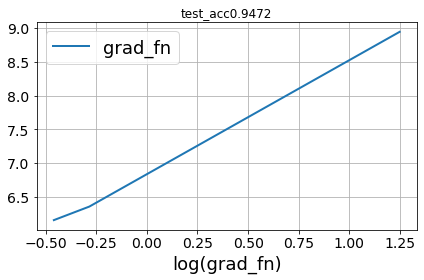

In [41]:
plt.plot([torch.log(x) for x in fn_norm], [torch.log(x) for x in grad_norm], linewidth=2, label='grad_fn')
plt.locator_params(axis='x', nbins=8)
plt.legend(prop={'size': 10})
axes = plt.gca()
plt.xlabel("log(output_norm)", color='k')
plt.ylabel("log(grad_output_norm)", color='k')
plt.legend(loc='best', prop={'size': 18})
plt.title('test_acc{}'.format(val_acc[-1]))
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('fn_grad')
plt.savefig('fn_grad.pdf')

In [ ]:
plt.plot([torch.log(x) for x in fn_norm], [torch.log(x) for x in hn], linewidth=2, label='grad_fn')
plt.locator_params(axis='x', nbins=8)
plt.legend(prop={'size': 10})
axes = plt.gca()
plt.xlabel("log(output_norm)", color='k')
plt.ylabel("log(hessian_output_norm)", color='k')
plt.legend(loc='best', prop={'size': 18})
plt.title('test_acc{}'.format(val_acc[-1]))
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('fn_hessian')
plt.savefig('fn_hessian.pdf')